In [1]:
%matplotlib notebook
%matplotlib notebook

## variously damped

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

In [3]:
f = 2 # Hz
wn = 2*np.pi*f
zeta = 0.05

t = np.linspace(0,2,1000)
y = np.sin(wn*t)

yunder = y*np.exp(-zeta*wn*t)
ycritical = y*np.exp(-1*wn*t)
yover = y*np.exp(-1*1.1*wn*t)

<IPython.core.display.Javascript object>


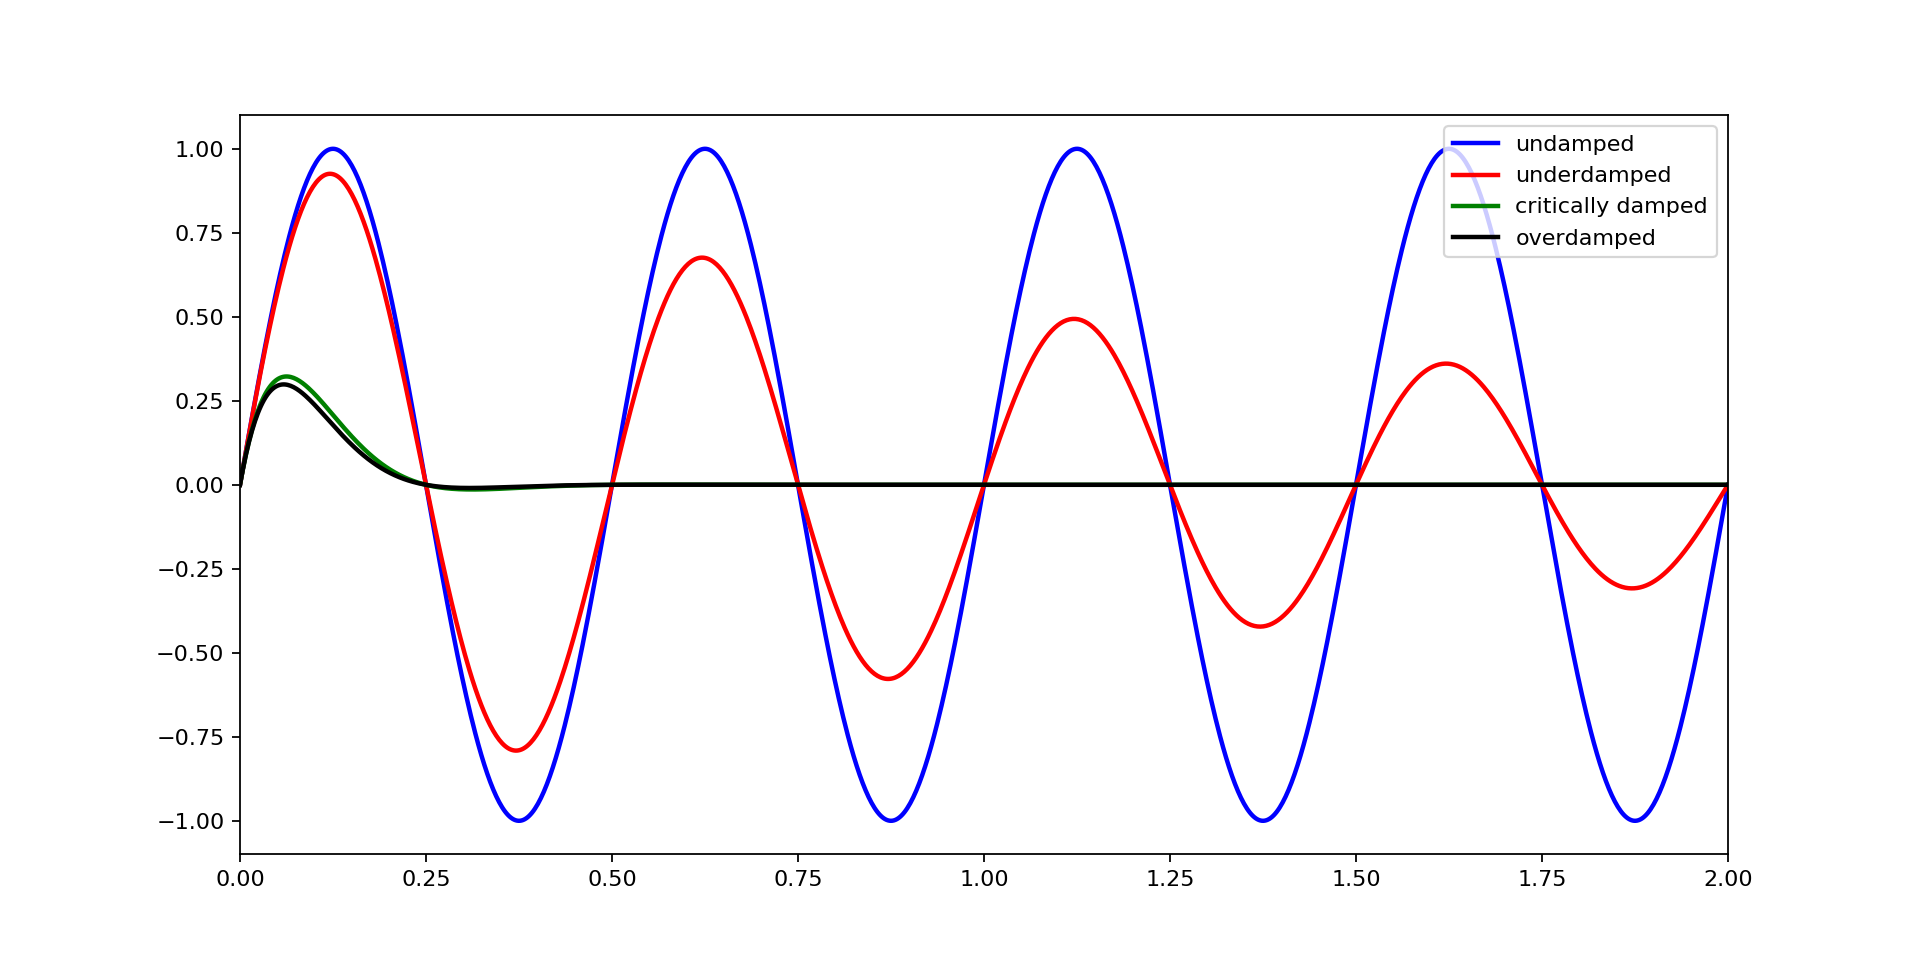

In [4]:
fig, ax = plt.subplots(figsize=(12,6), dpi=80)

ax.plot(t,y, color="blue", linewidth=2, label="undamped")
ax.plot(t,yunder, color="red", linewidth=2, label="underdamped")
ax.plot(t,ycritical, color="green", linewidth=2, label="critically damped")
ax.plot(t,yover, color="black", linewidth=2, label="overdamped")

ax.set(xlim=(0, 2), ylim=(-1.1, 1.1))
ax.legend(loc ='upper right')

<IPython.core.display.Javascript object>


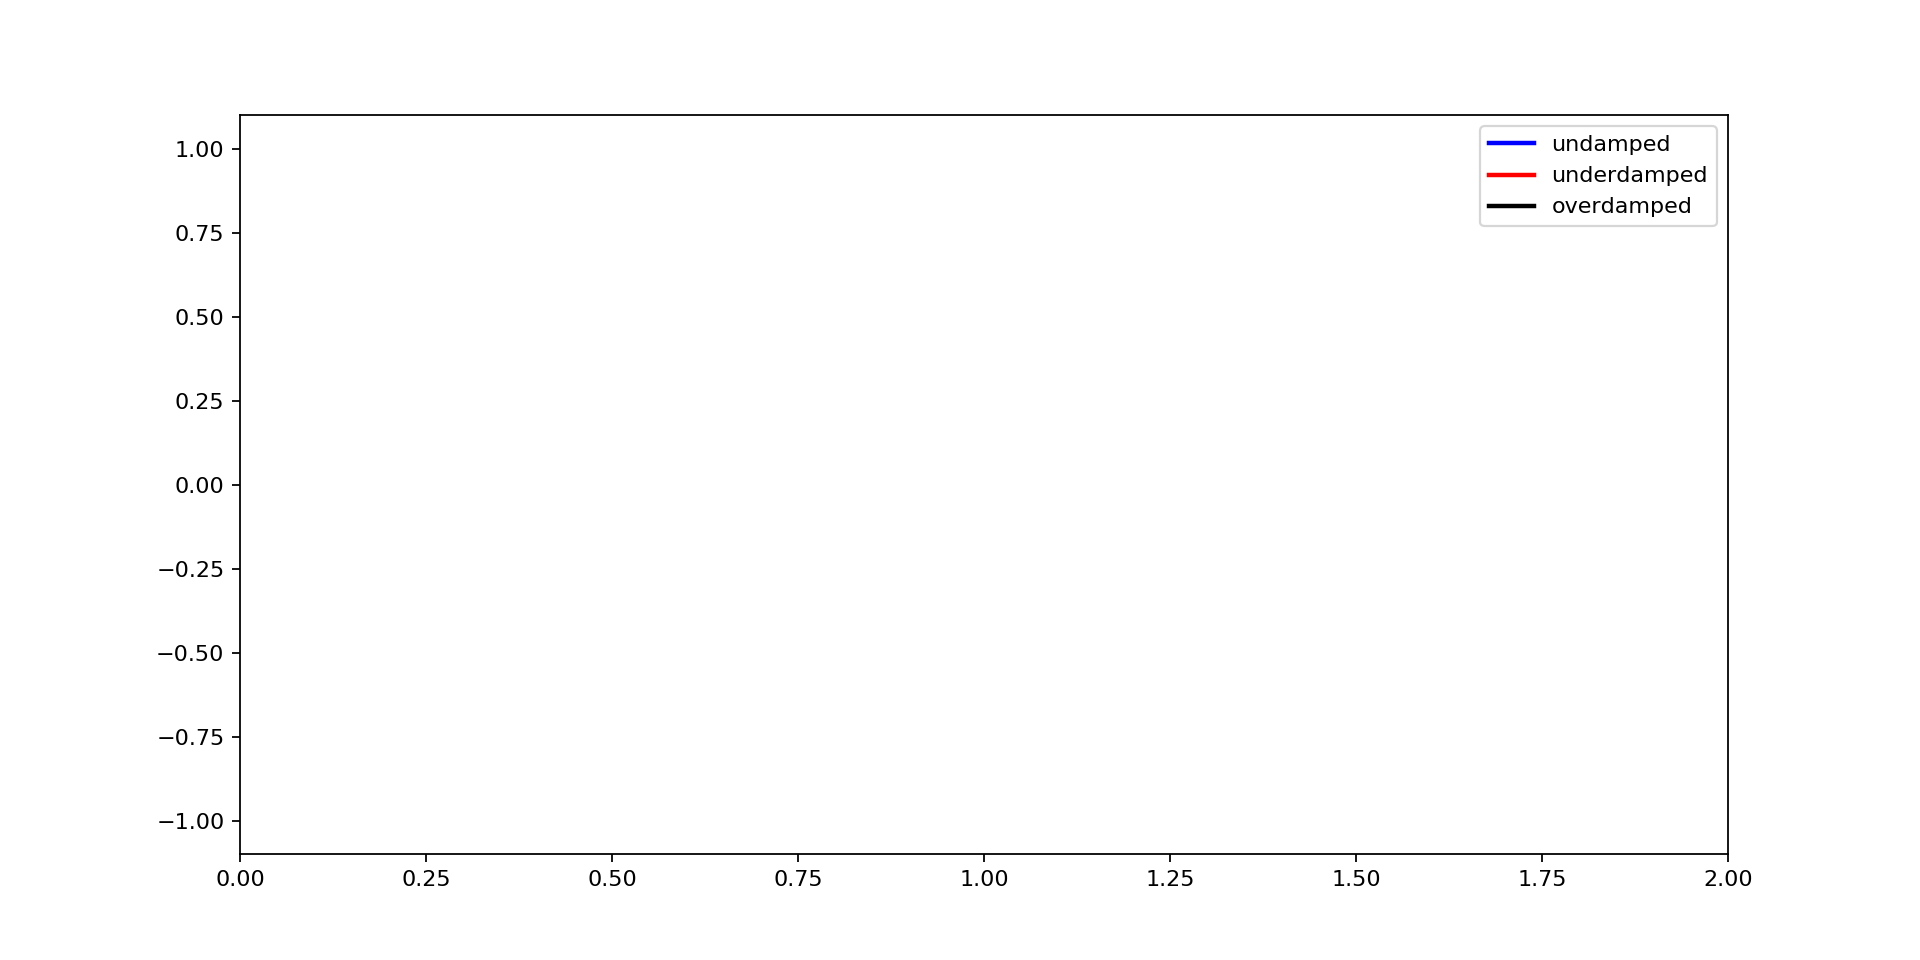

In [5]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(12,6), dpi=80)

undamped, = ax.plot([], [], linewidth=2, color='blue', label="undamped")
damped, = ax.plot([], [], linewidth=2, color='red', label="underdamped")
overdamped, = ax.plot([], [], linewidth=2, color='black', label="overdamped")

ax.set(xlim=(0, 2), ylim=(-1.1, 1.1))
ax.legend(loc ='upper right')

# animation stuff
def init():
    undamped.set_data([], [])
    damped.set_data([], [])
    overdamped.set_data([], [])
    return line,

def update(frame):
    undamped.set_data(t[:frame], y[:frame])
    damped.set_data(t[:frame], yunder[:frame])
    overdamped.set_data(t[:frame], yover[:frame])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=1000, interval=1, 
                               blit=False,
                               repeat=False)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


## mass spring

In [8]:
# Stefan van der Walt <stefan@sun.ac.za>, 2013
# License: CC0
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle


# Workaround to matplotlib bug in FunctionAnimator that won't allow us
# to specify ``itertools.count(step=delta)`` as the frames argument.
# Also see ``set_time`` below.
delta = 0.02

class FreeDamped:
    def __init__(self, k, m, c, u0, u0_prime):
        self.wn = np.sqrt(k / m)
        self.zeta = c/(2*m*self.wn)
        
        self.B = u0
        self.A = u0_prime / self.wn

    def __call__(self, t):
        A, B, wn, zeta = self.A, self.B, self.wn, self.zeta
        return A * np.exp(-zeta*wn*t) * np.sin(wn*t) + B * np.exp(-zeta*wn*t) * np.cos(wn*t)
    

class Spring:
    N = 100
    _hist_length = 100

    _spring_coords = np.zeros(N)
    _spring_coords[30:70] = 0.05 * (-1) ** np.arange(40)

    def __init__(self, axis, axis_history, k, m, c, u0, u0_prime):
        self._method = FreeDamped(k, m, c, u0, u0_prime)

        self._t = 0
        self._anchor = axis.vlines([0], -0.1, 0.1, linewidth=5, color='black')
        self._pot = Circle((self.u, 0), 0.05, color='black')
        self._spring, = axis.plot(*self._spring_xy(), color='black')

        axis.vlines([1], -0.1, -0.2)
        axis.text(1, -0.25, '$u = 0$', horizontalalignment='center')

        self._ax = axis
        axis.add_patch(self._pot)
        axis.set_xlim([0, 2])
        axis.set_ylim([-0.3, 0.2])
        axis.set_axis_off()
        axis.set_aspect('equal')

        self._history = [self.u - 1] * self._hist_length
        self._history_plot, = axis_history.plot(np.arange(self._hist_length) *
                                                delta, self._history)
        axis_history.annotate('Now',
                              (self._hist_length * delta, 1.5),
                              (self._hist_length * delta, 1.8),
                              arrowprops=dict(arrowstyle='->'),
                              horizontalalignment='center')
        axis_history.set_ylim(-2, 1.5)
        axis_history.set_xticks([])
        axis_history.set_xlabel(r'$\mathrm{Time}$')
        axis_history.set_ylabel(r'$\mathrm{Position,\, u}$')

    def _spring_xy(self):
        return np.linspace(0, self.u, self.N), self._spring_coords

    def set_time(self, t):
        self._t = t * delta
        self.update()

    @property
    def u(self):
        return 1 + self._method(self._t)

    def update(self):
        self._pot.center = (self.u, 0)

        x, y = self._spring_xy()
        self._spring.set_xdata(x)

        self._history.append(self.u - 1)
        self._history = self._history[-self._hist_length:]

        self._history_plot.set_ydata(self._history)

In [9]:
m = 1
k = 100
c = 1
# set initial conditions
u0 = 0.5
u0_prime = 0

sdof = FreeDamped(m,k,c,u0,u0_prime)

print('Natural frequency: ',sdof.wn)
print('Damping ratio: ', sdof.zeta)

Natural frequency:  0.1
Damping ratio:  0.05


<IPython.core.display.Javascript object>


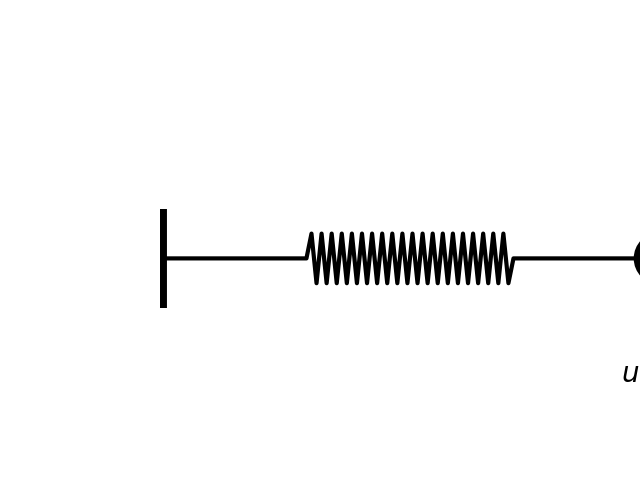

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1)
s = Spring(axis=ax0, axis_history=ax1,
           k=k, m=m, c=c, u0=u0, u0_prime=u0_prime)

anim = animation.FuncAnimation(fig, s.set_time, interval=delta * 2000,
                              repeat=False)

plt.show()

In [16]:
anim.save('sdof.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


In [11]:
from IPython.display import HTML

In [12]:
HTML(anim.to_html5_video())
